# Comparative Analysis of **SIFT/BoW**, CNNs, and SSL Techniques for Image Classification
Supervised Learning A.Y 2023/24 \
_Alessio De Luca 919790_ |
_Simone Vaccari 915222_  |
_Davide Vettore 868855_

### Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import joblib
from PIL import Image
import cv2

import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

# from sklearn.cluster import KMeans                       not feasible
from sklearn.cluster import MiniBatchKMeans

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC                               alternatives
#from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## Load the Data
> The scripts have been run on the Kaggle framework, the preprocessed data is stored [here](https://www.kaggle.com/datasets/momiqb/ifoodbalanced).

In [ ]:
path = '/kaggle/input/ifoodbalanced/'

train_df = pd.read_csv(path + 'balanced_trainset.csv')
valid_df = pd.read_csv(path + 'valset.csv')
test_df = pd.read_csv(path + 'val_labels.csv')

train_val_img_dir = path + 'train_set/train_set/'
test_img_dir = path + 'val_set/val_set/'

## Dataset and Dataloaders

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name, label = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, img_name)).convert('RGB')

        # Convert to numpy array
        img = np.array(img)

        # Apply transformations if any
        if self.transform:
            img = self.transform(image=img)['image']

        return img, label

In [ ]:
transform = A.Compose([
    A.Resize(width=512, height=512),
    ToTensorV2(),
])

BATCH_SIZE = 64
NUM_WORKERS = 4

# Initialize dataset and dataloaders
train_dataset = FoodDataset(train_df, train_val_img_dir, transform=transform)
valid_dataset = FoodDataset(valid_df, train_val_img_dir, transform=transform)
test_dataset = FoodDataset(test_df, test_img_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

**The preprocessing steps that work well for CNNs may not be optimal for SIFT-based approaches.**

> Data augmentation is crucial for CNNs because it helps create more varied training samples, reducing overfitting and improving generalization. CNNs benefit from seeing multiple versions of the same image during training. However, it's less beneficial for SIFT because SIFT features are typically extracted only once per image. Augmenting the images doesn't help much because we're not training a model to learn from these transformations, we're just extracting descriptors. In fact, augmentations might add unnecessary noise or alter keypoints, making the **descriptors less consistent across similar images**. \
\
In the CNNs pipeline the images were resized to 256x256 to reduce computational cost. SIFT may benefit from larger image sizes because more pixels mean more potential keypoints and descriptors. The 512x512 size could help SIFT capture more detailed and varied features, which might improve the quality of the BoW representations. \
\
Normalization is standard practice for CNNs as it helps the network converge faster and more reliably by keeping the input data in a consistent range. For SIFT, normalization isn't necessary because SIFT works on raw pixel values to find gradients and keypoints. Normalizing the images might not provide any significant advantage and could potentially alter the pixel intensity values in a way that changes keypoint detection.


## SIFT + BoW

> **The Scale-Invariant Feature Transform** (SIFT) is a robust computer vision algorithm for detecting and describing local features in images. In this approach, SIFT is used to extract image descriptors, which are then clustered using a **Bag of Words** (BoW) approach. The BoW dictionary is then employed for image classification, paired with a traditional classifier.



**OpenCV [SIFT_create parameters:](https://docs.opencv.org/4.x/d7/d60/classcv_1_1SIFT.html)**

- nfeatures: The number of best features to retain. The features are ranked by their scores (measured in SIFT algorithm as the local contrast)
- nOctaveLayers: The number of layers in each octave. 3 is the value used in D. Lowe paper. The number of octaves is computed automatically from the image resolution.
- contrastThreshold: The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions. The larger the threshold, the less features are produced by the detector.
- edgeThreshold: The threshold used to filter out edge-like features. Note that the its meaning is different from the contrastThreshold, i.e. the larger the edgeThreshold, the less features are filtered out (more features are retained).
- sigma: The sigma of the Gaussian applied to the input image at the octave #0. If your image is captured with a weak camera with soft lenses, you might want to reduce the number.
- descriptorType: The type of descriptors. Only CV_32F and CV_8U are supported.
- enable_precise_upscale: Whether to enable precise upscaling in the scale pyramid, which maps index  to . This prevents localization bias. The option is disabled by default.

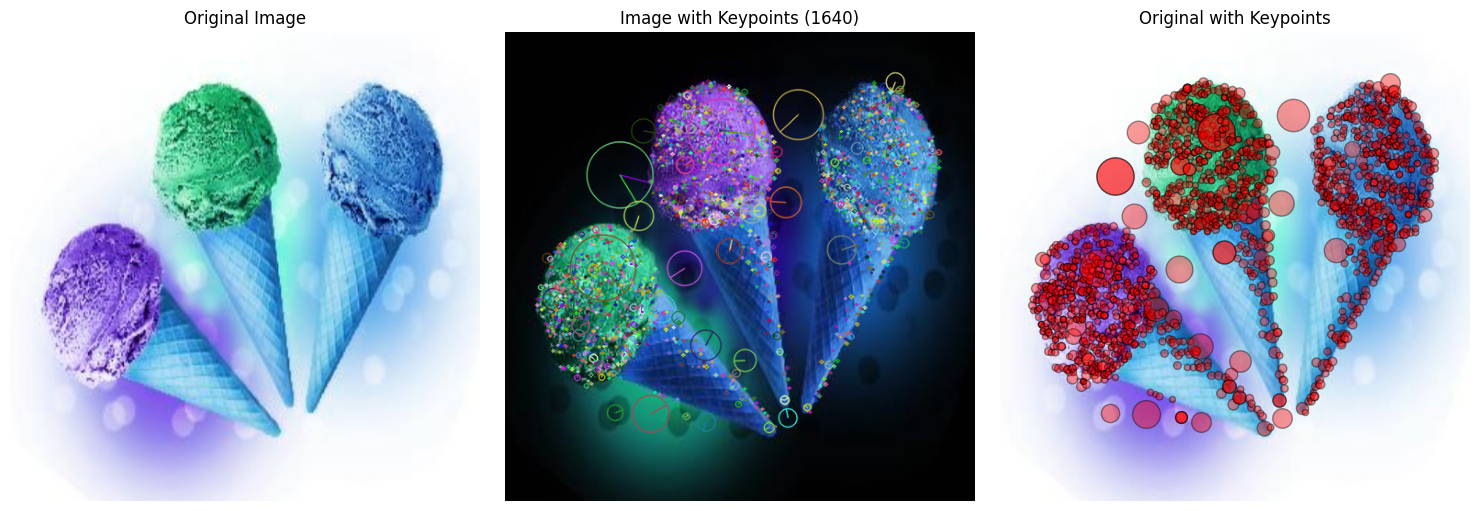

In [ ]:
# SIFT visualization

def visualize_keypoints_on_image(original_image, image_with_keypoints, keypoints):
    '''
    This uses the descriptors extracted from the following function to produce a more
    complex, color encoded visualization.
    '''

    img_rgb_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    img_rgb_with_keypoints = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)


    plt.figure(figsize=(15, 5))

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb_original)
    plt.title("Original Image")
    plt.axis('off')

    # Plot the cv2 processed image with keypoints drawn
    plt.subplot(1, 3, 2)
    plt.imshow(img_rgb_with_keypoints)
    plt.title(f"Image with Keypoints ({len(keypoints)})")
    plt.axis('off')

    # Plot the original image with manual keypoints
    plt.subplot(1, 3, 3)
    plt.imshow(img_rgb_original)

    for kp in keypoints:
        x, y = kp.pt
        size = kp.size  # diameter obtained from the size parameter (then enlarged)
        plt.scatter(x, y, s=size*10, c='red', edgecolor='black', alpha=0.4, marker='o')

    plt.title("Original with Keypoints")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_feature_maps(loader):
    '''
    An unbounded set of descriptors is extracted from a random image, the output is used
    to produce a more complex, color encoded visualization.
    '''
    sift = cv2.SIFT_create()

    for images, _ in loader:
        break

    # Get the first image from the batch and process for cv2
    img_og = images[0].numpy().transpose(1, 2, 0)
    img = (img_og * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Convert image to grayscale for SIFT
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    keypoints, _ = sift.detectAndCompute(gray, None)

    # Draw keypoints on the processed image
    img_with_keypoints = cv2.drawKeypoints(img_bgr,
                                           keypoints,
                                           None,
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    visualize_keypoints_on_image(img_og, img_with_keypoints, keypoints)

visualize_feature_maps(train_loader)

**Reasoning behind the current approach**

> Our initial approach involved extracting a fixed number of descriptors from all the images in the training set. In the second step, these descriptors were clustered using an algorithm to form the Bag of Features. However, this method had two main limitations. The most obvious one was the complexity of the KMeans algorithm (see note). Even extracting just 200 descriptors per image from the entire training set would require over 1.5 trillion operations, leading to an estimated computational time of more than 14 hours. This suggested us to switch to MiniBatchKMeans, a simpler and less computationally intensive alternative. \
The second limitation occurred in the descriptor extraction phase, as soon as we started experimenting with more than 200 descriptors per image (a legitimate attempt given that without constraints, over 3000 descriptors per image were extracted), our 30 GiB RAM couldn’t handle the load. Particularly, stacking the descriptors at the end, which essentially doubled the RAM usage, caused the system to run out of memory with just over 300 descriptors per image. \
\
These two limitations led us to adjust our pipeline, ultimately for the better. Since MiniBatchKMeans, our most feasible alternative to KMeans, already processes descriptors in batches, we decided to merge the two steps. Now, using data loaders, a set number of descriptors were extracted from the images, with the batch size of descriptors different from the one used in the data loaders. The MiniBatchKMeans algorithm is then partially fitted on this batch of descriptors. Afterward, the batch is cleared, freeing up RAM, and the process is repeated, each time improving the MiniBatchKMeans fit until all descriptors have been processed.

**_NOTE: Time Complexity of K-Means_**

Kmeans, or a clustering algorithm in general, is needed to learn the visual vocaboulary for the BOW approach.

The time complexity of k-means is approximately $O(n*k*t*d)$ with:
- $n$ number of descriptors (all_descriptors.shape[0])
- $k$ number of clusters
- $t$ number of iterations
- $d$ dimensionality of the descriptors (all_descriptors.shape[1])

Plugging in the numbers we get the number of operations that must be computed.

Our system has 4 CPUs @ 2.00GHz, which means 2 billions cycles per second per core, so a total of 8 billion cycles. Scalar operations (the one used for kmeans) usually takes a single cycle, so, with parallelization, we can expect 8 billion operations per second. (!lscpu)

- Downsampling to 5 images per label and bounding the number of descriptors per image to 200 we get 250.869 descriptors of dimensionality 128. Setting the clusters to 500 and the max_iterations to 100 we get a total of 1.605.561.600.000 operations. Kmeans can't be parallelized so we can just use one core (2.000.000.000 scalar operations per second) the training should take around 800 seconds (13 minutes). **In practice it tooks 948.47 seconds (15 minutes)**

- The entire dataset of images leads to 16.606.593 descriptors if 200 per images are extracted. With the same constrains saw above we expect 106.282.000.000.000 operations, and an estimated time of 885 minutes (15 hours) .


MiniBatchKMeans is less complex, we can compute the required operations with $b$ batch_size instead of $n$ total number of descriptors. For this reason, we can try to increase the number of descriptor per image and increase the number of cluster and max_iterations while keeping the computational cost accessible.


In [ ]:
# Not mandatory, just to check ram usage during the descriptors extraction process

!pip install psutil
import psutil

def print_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    print(f"Memory usage - RSS: {memory_info.rss / (1024 ** 3):.2f} GB, VMS: {memory_info.vms / (1024 ** 3):.2f} GB")

print_memory_usage()

Memory usage - RSS: 0.47 GB, VMS: 2.13 GB


In [ ]:
# SIFT feature extraction in batches and MiniBatchKMeans fitting

n_clusters = 500        # size of the visual vocaboulary
n_iter = 300            # max iteration allowed for K-Means convergence
batch_size = 250000     # batch size of the descriptors used for partial fitting before freeing up RAM

minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=batch_size, max_iter=n_iter, n_init='auto')


def extract_sift_features_batch(images):
    sift = cv2.SIFT_create(nfeatures=1000)  # Adjusted number of features to extract
    all_descriptors = []

    for img in images:
        img = img.numpy().transpose(1, 2, 0)
        img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)

        if descriptors is not None:
            all_descriptors.append(descriptors)
        else:
            all_descriptors.append(np.array([]))

    return all_descriptors


# Process the dataset in manageable batches

for images, _ in tqdm(train_loader):
    #print_memory_usage()                                             # Just to make sure the RAM gets cleared
    descriptors_batch = extract_sift_features_batch(images)
    descriptors_batch = [d for d in descriptors_batch if d.size > 0]  # Filter out empty descriptor arrays

    if descriptors_batch:  # If there are descriptors in the batch
        descriptors_batch = np.vstack(descriptors_batch)

        # Incremental fit to MiniBatchKMeans
        minibatch_kmeans.partial_fit(descriptors_batch)

        del descriptors_batch  # Free up memory


joblib.dump(minibatch_kmeans, 'minibatch_kmeans_model.pkl')    # Save the model

print("MiniBatchKMeans clustering completed.")

  0%|          | 0/1299 [00:00<?, ?it/s]

MiniBatchKMeans clustering completed.


In [ ]:
# BOW histograms

def compute_bow_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None and len(descriptors) > 0:
            visual_words = kmeans.predict(descriptors)
            bow_histogram = np.bincount(visual_words, minlength=kmeans.n_clusters)
        else:
            bow_histogram = np.zeros(kmeans.n_clusters)
        histograms.append(bow_histogram)
    return np.array(histograms)

def extract_bow_features(loader, kmeans):
    features = []
    labels = []

    for images, batch_labels in tqdm(loader):
        descriptors_batch = extract_sift_features_batch(images)
        histograms = compute_bow_histograms(descriptors_batch, kmeans)
        features.extend(histograms)
        labels.extend(batch_labels.numpy())

    return np.array(features), np.array(labels)

# Extract BoW features and corresponding labels
train_features, train_labels = extract_bow_features(train_loader, minibatch_kmeans)
valid_features, valid_labels = extract_bow_features(valid_loader, minibatch_kmeans)
test_features, test_labels = extract_bow_features(test_loader, minibatch_kmeans)


# Save the features
joblib.dump(train_features, 'train_features.pkl')
joblib.dump(train_labels, 'train_labels.pkl')
joblib.dump(valid_features, 'valid_features.pkl')
joblib.dump(valid_labels, 'valid_labels.pkl')
joblib.dump(test_features, 'test_features.pkl')
joblib.dump(test_labels, 'test_labels.pkl')


  0%|          | 0/1299 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79d9460400d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x79d9460400d0>Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x79d9460400d0>

Traceback (most recent call last):
AssertionError  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
    self._shutdown_workers(): 
  File "/opt/conda/lib/python3.10/site-packages/to

  0%|          | 0/188 [00:00<?, ?it/s]

['test_labels.pkl']

## Traditional Classifier

In [ ]:
#  Logistic regression with z-score normalization

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(valid_features)
test_features_scaled = scaler.transform(test_features)

start_time = time.time()
classifier_norm = LogisticRegression(max_iter=1000)
classifier_norm.fit(train_features_scaled, train_labels)
end_time = time.time()
print(f"Time taken for LogisticRegression fitting: {(end_time - start_time)/60:.2f} minutes")

val_preds = classifier_norm.predict(val_features_scaled)
test_preds = classifier_norm.predict(test_features_scaled)

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')


print(f"Validation Accuracy: {accuracy_score(valid_labels, val_preds) * 100:.2f}%")
print(f"Test Accuracy: {accuracy_score(test_labels, test_preds) * 100:.2f}%")
print(f'Test Precision: {precision * 100:.2f}%')
print(f'Test Recall: {recall * 100:.2f}%')
print(f'Test F1 Score: {f1 * 100:.2f}%')

Time taken for LogisticRegression fitting: 9.84 minutes
Validation Accuracy: 5.34%
Test Accuracy: 6.26%


In [ ]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.0577
Recall: 0.0625
F1 Score: 0.0587


## Visualizations

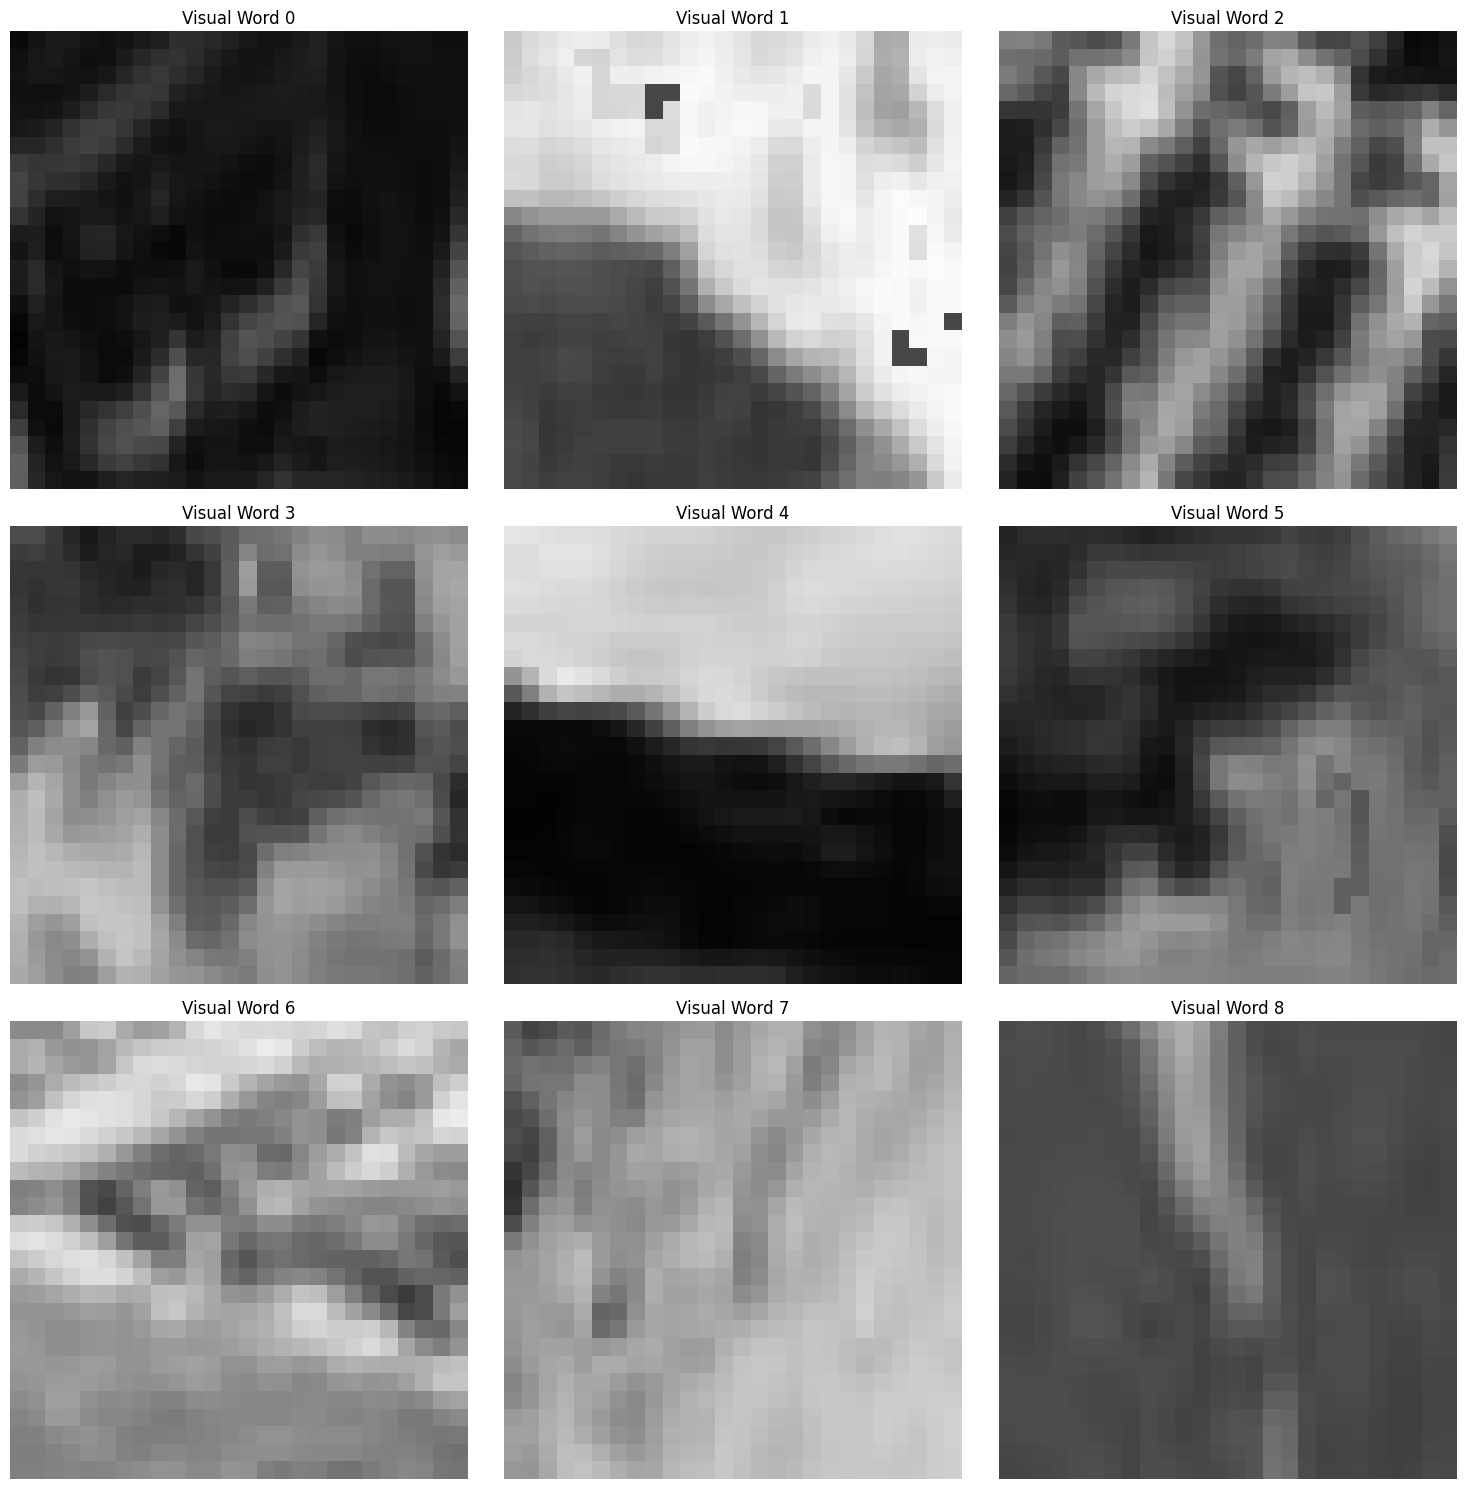

In [ ]:
# SIFT does not use color informations, it works on grayscale images


def visualize_cluster_centers(loader, kmeans_model, patch_size=0, grid_size=3):
    '''
    This function visualizes the most representative image patches corresponding to the cluster centers of a KMeans model.

    Parameters:
    - loader: Data loader containing batches of images.
    - kmeans_model: Trained KMeans model whose cluster centers are to be visualized.
    - patch_size: Size of the patch to be extracted around each keypoint. If not specified, the patch size will be determined based on the keypoint size (times 10).
    - grid_size: Size of the grid for plotting the representative patches (default is 3x3 patches).

    Functionality:
    - For each cluster center in the KMeans model, the function searches for the closest SIFT descriptor across all images in the provided batch.
    - The closest descriptor to each cluster center is identified, and the corresponding image patch is extracted and visualized.
    - The function assumes that a single batch of images is representative enough to contain relevant patches for each cluster in the visual vocabulary.
    '''

    for images, _ in loader:     # assumption that a single batch is enough (for computational reasons)
        break

    sift = cv2.SIFT_create(nfeatures=1000)  # initialize SIFT

    cluster_centers = kmeans_model.cluster_centers_

    # Prepare a grid for plotting
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    for i in range(grid_size * grid_size):
        center = cluster_centers[i]
        closest_descriptor = None
        closest_distance = float('inf')
        closest_image = None
        closest_kp = None

        for img in images:
            img_og = img.numpy().transpose(1, 2, 0)
            img_np = (img_og * 255).astype(np.uint8)
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

            keypoints, descriptors = sift.detectAndCompute(gray, None)

            if descriptors is not None:

                distances = np.linalg.norm(descriptors - center, axis=1)  # distance between centers and descriptors

                min_idx = np.argmin(distances)
                if distances[min_idx] < closest_distance:
                    closest_distance = distances[min_idx]
                    closest_descriptor = descriptors[min_idx]
                    closest_image = gray
                    closest_kp = keypoints[min_idx]
                    if patch_size == 0:
                        patch_size = int(round(closest_kp.size*10, 0))


        if closest_image is not None and closest_kp is not None:
            x, y = int(closest_kp.pt[0]), int(closest_kp.pt[1])
            patch = closest_image[max(0, y-patch_size//2):y+patch_size//2, max(0, x-patch_size//2):x+patch_size//2]  # closest_image is the real greyscale patch but you can also use img_og for colors

            ax = axes[i // grid_size, i % grid_size]
            ax.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
            ax.set_title(f"Visual Word {i}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()


visualize_cluster_centers(train_loader, minibatch_kmeans)

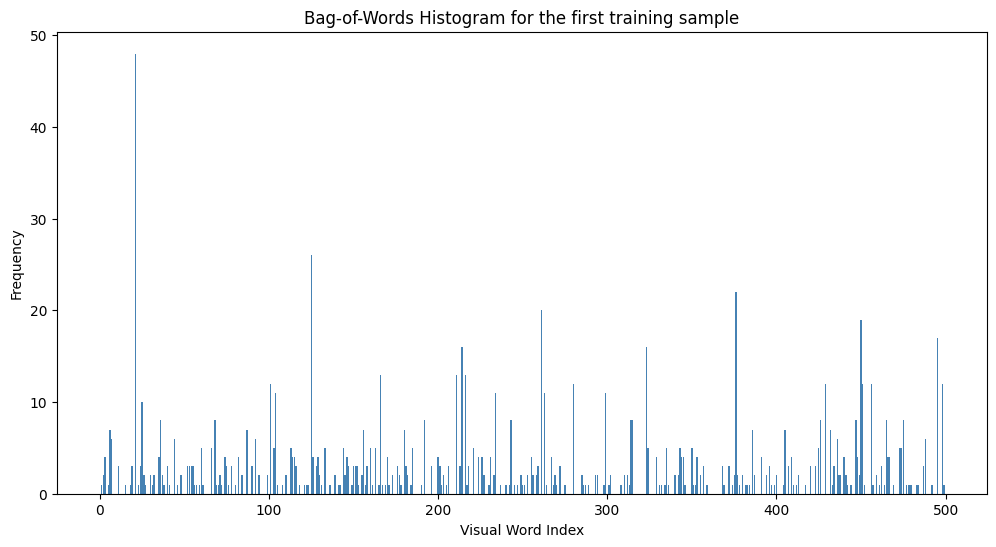

In [ ]:
# BoW histogram of a training sample

plt.figure(figsize=(12, 6))
plt.bar(range(len(train_features[0])), train_features[0], color='steelblue')
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.title('Bag-of-Words Histogram for the first training sample')
plt.show()

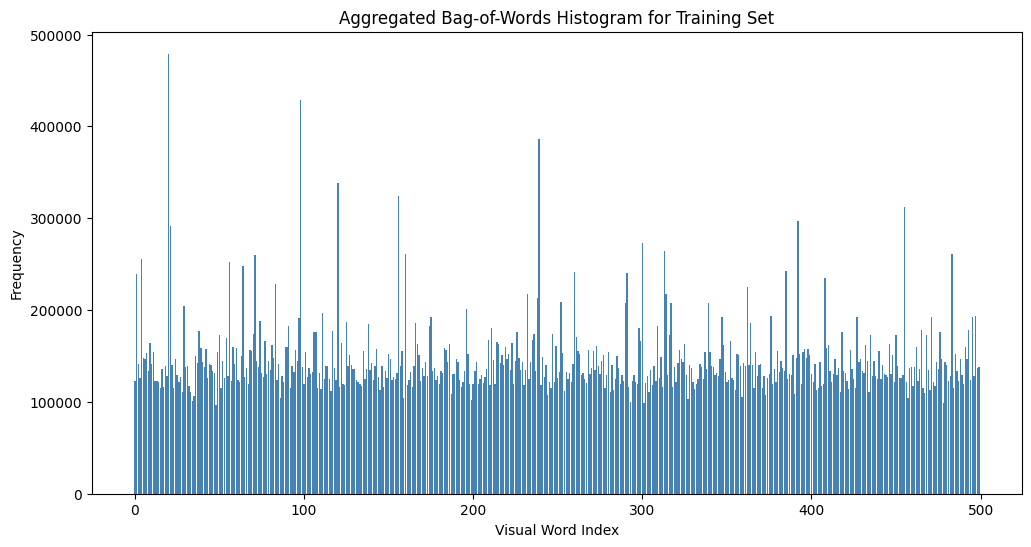

In [ ]:
# BoW histogram across the entire training set

aggregated_histogram = np.sum(train_features, axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(len(aggregated_histogram)), aggregated_histogram, color='steelblue')
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.title('Aggregated Bag-of-Words Histogram for Training Set')
plt.show()

In [ ]:
# index of the highest and lowest occurring visual words
highest_occurrence_index = np.argmax(aggregated_histogram)
lowest_occurrence_index = np.argmin(aggregated_histogram)

# corresponding frequencies
highest_occurrence_frequency = aggregated_histogram[highest_occurrence_index]
lowest_occurrence_frequency = aggregated_histogram[lowest_occurrence_index]

print(f"The highest occurring visual word is at index {highest_occurrence_index} with a frequency of {highest_occurrence_frequency}.")
print(f"The lowest occurring visual word is at index {lowest_occurrence_index} with a frequency of {lowest_occurrence_frequency}.")


The highest occurring visual word is at index 20 with a frequency of 479103.0.
The lowest occurring visual word is at index 48 with a frequency of 96466.0.


## Future developments:

- [Try different feature detection algorithm](https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html)
- [Introduce feature matching for classification rather than a traditional classifier](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)
- Try different clustering algorithms
- Try SIFT alternatives which works with colors (Early/Late fusion approaches)
- Try different traditional classifiers